#### Instruction
Update your previous backtester to class based backtester and with more ratios.
Build strategy backtesting class.

In [185]:
import numpy as np
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [186]:
class MA_Crossover():
    def __init__(self, symbol, benchmark, start, end, STMA_window, LTMA_window, interval):
        self.symbol = symbol
        self.benchmark = benchmark
        self.start = start
        self.end = end
        self.STMA_window = STMA_window
        self.LTMA_window = LTMA_window
        self.interval = interval

    def prepare_data(self):
        hist_stock = yf.Ticker(self.symbol).history(start=self.start, end=self.end)
        hist_bench = yf.Ticker(self.benchmark).history(start=self.start, end=self.end)
        df = pd.DataFrame()
        df['bench_Close'] = hist_bench['Close']
        df['Close'] = hist_stock['Close']
        df['STMA'] = df['Close'].rolling(window=self.STMA_window).mean()
        df['LTMA'] = df['Close'].rolling(window=self.LTMA_window).mean()
        df.dropna(inplace=True)
        df['stock_returns'] = np.log(1 + df['Close'].pct_change()) # note: log returns
        df['bench_returns'] = np.log(1 + df['bench_Close'].pct_change()) # note: log returns
        
        self.df = df 
        return df

    def strategy(self):
        bt = self.df.copy()
        
        bt['str_position'] = np.where(bt['STMA'] > bt['LTMA'], 1, -1)
        bt['str_returns'] = bt['str_position'].shift(1) * bt['stock_returns'] # today's return is based on yesterday's position
        bt['str_drawdown'] = bt['str_returns'].cumsum().cummax() - bt['str_returns'].cumsum()
        bt['str_signal'] = bt['str_position'].diff()
        bt.iloc[0, bt.columns.get_loc('str_signal')] = 2 if bt['str_signal'].iloc[0] == 1 else -2

        self.bt = bt
        return bt

    def visualize_strategy(self):
        bt = self.bt.copy()

        # Visualising the strategy from the bt dataframe
        plt.figure(figsize=(15, 5))
        plt.plot(bt['Close'] ,color='black', label='Price', linestyle='dashed')
        plt.plot(bt['STMA'], color='b', label='Short term MA')
        plt.plot(bt['LTMA'], color='r', label='Long term MA')

        # plot ‘buy crossover’ signals
        plt.plot(bt[bt['str_signal'] == 2].index,
                bt['STMA'][bt['str_signal'] == 2],
                '^', markersize = 15, color = 'g', label = 'buy/long')

        # plot ‘sell crossover’ signals
        plt.plot(bt[bt['str_signal'] == -2].index,
                bt['STMA'][bt['str_signal'] == -2],
                'v', markersize = 15, color = 'r', label = 'sell/short')

        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.title('Moving Averages Crossover {} Vs {}'.format(self.STMA_window, self.LTMA_window))
        plt.legend()
        plt.grid()
        plt.show()
        
    def performance(self):
        bt = self.bt.copy()
        stock_return, str_return = bt[['stock_returns', 'str_returns']].sum().apply(np.exp) - 1


        # 1. Drawdown
        # Cumsum returns the cummulative of a series
        bt['Cumulative_Returns'] = bt['str_returns'].cumsum()

        # Cummax always returns the Maximum of the the cumulative
        bt['Maximum_Returns'] = bt['Cumulative_Returns'].cummax()

        # Store the differences in a new colum 'drawdowns'
        # Note that we are calculating the drawdowns from cumsum of returns which is already in percentage.
        bt['drawdowns'] = bt['Maximum_Returns'] - bt['Cumulative_Returns']

        # The maximum difference is refered as 'Drawdown'
        max_drawdown = bt['drawdowns'].max()
        print('The max drawdown is', max_drawdown)

        # 2. Calmar Ratio
        calmar_ratio = str_return / max_drawdown

        # 3. Information Ratio
        bt['str-bench'] = bt['str_returns'] - bt['bench_returns']

        # average of difference
        average_of_difference = bt['str-bench'].mean()

        # Tracking error
        std_dev_of_difference = bt['str-bench'].std()

        # Information Ratio daily
        IR_daily =  average_of_difference / std_dev_of_difference

        # Covert to annual
        IR_annual = IR_daily * (252**0.5)

        # Similar to what we did in the  BASS notebook. Prepare a covariance matrix
        cov_matrix = bt[['str_returns', 'bench_returns']].cov()

        Beta = cov_matrix.iat[0,1] / cov_matrix.iat[1,1]

        Treynor_ratio = str_return / Beta

        # 4. Sortino Ratio
        # Create a new series with positive returns converted to 0 and negative returns as it is
        converted_returns = bt['str_returns'].apply(lambda x: 0 if x > 0 else x)
        converted_reg_returns = np.exp(converted_returns)-1

        squared_converted_returns = converted_reg_returns ** 2

        squared_sum = np.sum(squared_converted_returns)
        len_squared_sum = len(converted_returns)

        downside_deviation = np.sqrt(squared_sum/len_squared_sum)

        # Calculate annualised downside dev
        annual_converted_sd = downside_deviation * np.sqrt(252)

        # Calculate Sortino
        sortino = str_return / annual_converted_sd

        print(f'Stock Return: {stock_return:.2%}')
        print(f'Strategy Return: {str_return:.2%}')
        print(f'Calmar Ratio: {calmar_ratio:.2f}')
        print(f'Information Ratio: {IR_annual:.2f}')
        print(f'Treynor Ratio: {Treynor_ratio:.2f}')
        print(f'Sortino Ratio: {sortino:.2f}')

        Long_Days = len(bt[bt['str_position'] == 1.0])
        Short_Days = len(bt[bt['str_position'] == -1.0])
        No_Trading_Days = len(bt[bt['str_position'] == 0])

        print(f'\nLong Days: {Long_Days}')
        print(f'Short Days: {Short_Days}')
        print(f'No Trading Days: {No_Trading_Days}')

        self.bt = bt

        performance = {
            'stock_return': stock_return,
            'str_return': str_return,
            'calmar_ratio': calmar_ratio,
            'IR_annual': IR_annual,
            'Treynor_ratio': Treynor_ratio,
            'sortino': sortino,
            'Long_Days': Long_Days,
            'Short_Days': Short_Days,
            'No_Trading_Days': No_Trading_Days
        }
        performance = pd.DataFrame(performance, index=[f"{self.STMA_window} Vs {self.LTMA_window}"])

        return performance

    def returns_plot(self):
        bt = self.bt.copy()
        bt[['stock_returns', 'str_returns']].cumsum().plot()

    def drawdown_plot(self):
        bt = self.bt.copy()

        # The maximum difference is refered as 'Drawdown'
        max_drawdown = bt['drawdowns'].max()
        print('The max drawdown is', max_drawdown)

        # Visualise drawdowns
        bt[['Cumulative_Returns', 'Maximum_Returns']].dropna().plot()
        
    

In [187]:
SIA_MA = MA_Crossover('C6L.SI', '^STI', '2020-01-01', '2023-12-31', 50, 200, '1d')

prepared_data = SIA_MA.prepare_data()
prepared_data


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,bench_Close,Close,STMA,LTMA,stock_returns,bench_returns
Date,,,,,,
2020-10-21 00:00:00+08:00,2525.610107,3.267007,3.317455,4.088666,NaN,NaN
2020-10-22 00:00:00+08:00,2528.409912,3.294930,3.314290,4.075269,0.008511,0.001108
2020-10-23 00:00:00+08:00,2537.389893,3.332161,3.310381,4.062354,0.011236,0.003545
2020-10-26 00:00:00+08:00,2523.310059,3.369392,3.308333,4.049920,0.011111,-0.005564
2020-10-27 00:00:00+08:00,2512.870117,3.341469,3.305913,4.037084,-0.008322,-0.004146
...,...,...,...,...,...,...
2023-12-22 00:00:00+08:00,3140.320068,6.430000,6.201750,6.305019,0.014096,0.008898
2023-12-26 00:00:00+08:00,3139.979980,6.420000,6.203356,6.309727,-0.001556,-0.000108
2023-12-27 00:00:00+08:00,3170.760010,6.440000,6.207528,6.314725,0.003110,0.009755


In [188]:
str = SIA_MA.strategy()
str

,bench_Close,Close,STMA,LTMA,stock_returns,bench_returns,str_position,str_returns,str_drawdown,str_signal
Date,,,,,,,,,,
2020-10-21 00:00:00+08:00,2525.610107,3.267007,3.317455,4.088666,NaN,NaN,-1,NaN,NaN,-2.0
2020-10-22 00:00:00+08:00,2528.409912,3.294930,3.314290,4.075269,0.008511,0.001108,-1,-0.008511,0.000000,0.0
2020-10-23 00:00:00+08:00,2537.389893,3.332161,3.310381,4.062354,0.011236,0.003545,-1,-0.011236,0.011236,0.0
2020-10-26 00:00:00+08:00,2523.310059,3.369392,3.308333,4.049920,0.011111,-0.005564,-1,-0.011111,0.022347,0.0
2020-10-27 00:00:00+08:00,2512.870117,3.341469,3.305913,4.037084,-0.008322,-0.004146,-1,0.008322,0.014025,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+08:00,3140.320068,6.430000,6.201750,6.305019,0.014096,0.008898,-1,-0.014096,0.231898,0.0
2023-12-26 00:00:00+08:00,3139.979980,6.420000,6.203356,6.309727,-0.001556,-0.000108,-1,0.001556,0.230342,0.0
2023-12-27 00:00:00+08:00,3170.760010,6.440000,6.207528,6.314725,0.003110,0.009755,-1,-0.003110,0.233452,0.0


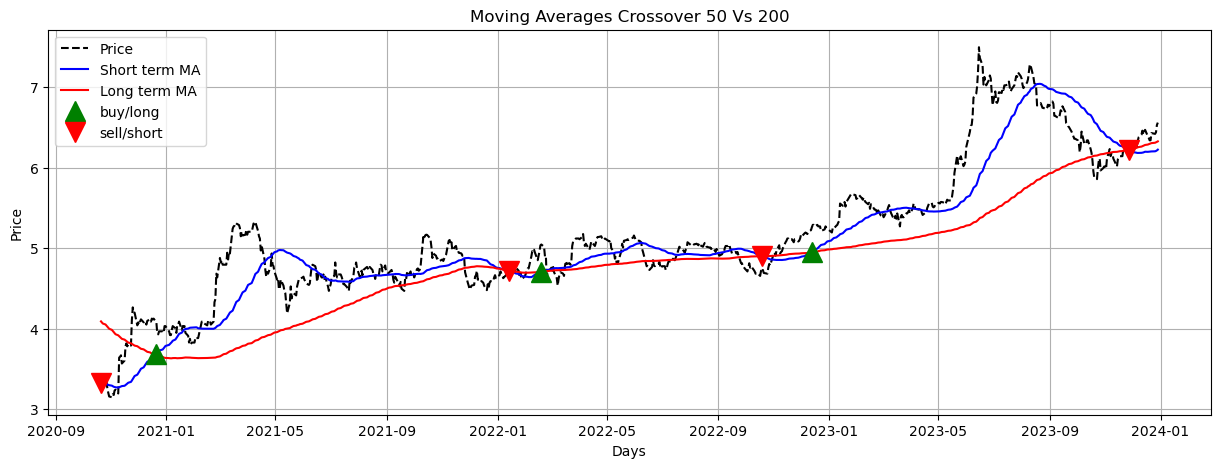

In [189]:
SIA_MA.visualize_strategy()


In [190]:
SIA_MA.performance()

The max drawdown is 0.395211907246887
Stock Return: 100.80%
Strategy Return: -18.65%
Calmar Ratio: -0.47
Information Ratio: -0.64
Treynor Ratio: -0.31
Sortino Ratio: -1.14

Long Days: 674
Short Days: 129
No Trading Days: 0


,stock_return,str_return,calmar_ratio,IR_annual,Treynor_ratio,sortino,Long_Days,Short_Days,No_Trading_Days
50 Vs 200,1.007954,-0.186514,-0.471934,-0.63636,-0.311904,-1.139755,674,129,0


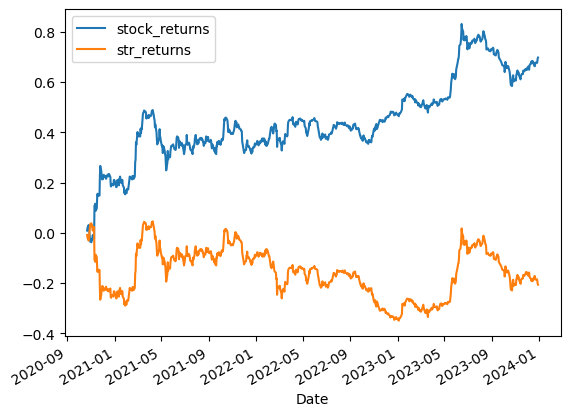

In [191]:
SIA_MA.returns_plot()

The max drawdown is 0.395211907246887


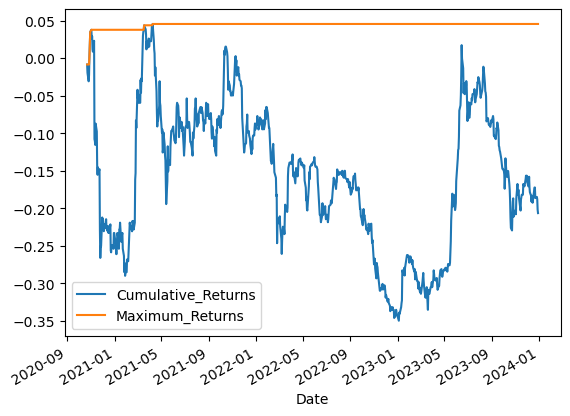

In [192]:
SIA_MA.drawdown_plot()

Use the class to perform backtest on different moving average strategies and compare the results

In [197]:
MA_strategies = [
    [5, 21],
    [50, 100],
    [50, 200],
    [100, 200],
    [100, 150],
    [150, 200]
]

all_performances = []
for strat in MA_strategies:
    SIA_MA = MA_Crossover('C6L.SI', '^STI', '2020-01-01', '2023-12-31', strat[0], strat[1], '1d')
    SIA_MA.prepare_data()
    SIA_MA.strategy()
    performance = SIA_MA.performance()
    all_performances.append(performance)

all_performances = pd.concat(all_performances)
all_performances

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


The max drawdown is 0.7950000637474226
Stock Return: 17.00%
Strategy Return: 8.83%
Calmar Ratio: 0.11
Information Ratio: 0.04
Treynor Ratio: -0.16
Sortino Ratio: 0.47

Long Days: 534
Short Days: 448
No Trading Days: 0
The max drawdown is 0.4405198845691095
Stock Return: 84.50%
Strategy Return: -13.46%
Calmar Ratio: -0.31
Information Ratio: -0.41
Treynor Ratio: 1.12
Sortino Ratio: -0.81

Long Days: 533
Short Days: 370
No Trading Days: 0


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


The max drawdown is 0.3952117043545045
Stock Return: 100.80%
Strategy Return: -18.65%
Calmar Ratio: -0.47
Information Ratio: -0.64
Treynor Ratio: -0.31
Sortino Ratio: -1.14

Long Days: 674
Short Days: 129
No Trading Days: 0
The max drawdown is 0.3038232836671154
Stock Return: 100.80%
Strategy Return: 10.87%
Calmar Ratio: 0.36
Information Ratio: -0.20
Treynor Ratio: 0.18
Sortino Ratio: 0.68

Long Days: 690
Short Days: 113
No Trading Days: 0


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' ke

The max drawdown is 0.4121082693780971
Stock Return: 91.52%
Strategy Return: -6.37%
Calmar Ratio: -0.15
Information Ratio: -0.37
Treynor Ratio: -0.18
Sortino Ratio: -0.38

Long Days: 608
Short Days: 245
No Trading Days: 0
The max drawdown is 0.508886937960919
Stock Return: 100.80%
Strategy Return: -12.88%
Calmar Ratio: -0.25
Information Ratio: -0.51
Treynor Ratio: -0.33
Sortino Ratio: -0.76

Long Days: 630
Short Days: 173
No Trading Days: 0


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,stock_return,str_return,calmar_ratio,IR_annual,Treynor_ratio,sortino,Long_Days,Short_Days,No_Trading_Days
5 Vs 21,0.169961,0.088305,0.111075,0.041539,-0.156547,0.473199,534,448,0
50 Vs 100,0.845005,-0.134565,-0.305468,-0.413429,1.121314,-0.809676,533,370,0
50 Vs 200,1.007954,-0.186514,-0.471934,-0.636360,-0.311904,-1.139754,674,129,0
100 Vs 200,1.007954,0.108660,0.357642,-0.203890,0.181946,0.675127,690,113,0
100 Vs 150,0.915195,-0.063711,-0.154599,-0.374170,-0.178666,-0.381751,608,245,0
150 Vs 200,1.007954,-0.128809,-0.253119,-0.514364,-0.325799,-0.764384,630,173,0
